## Exercício: Modelo de Linguagem com auto-atenção e máscaras causais

Seguimos na mesma linha de treinar um modelo de linguagem a partir dos textos de Machado de Assis.

Neste exercício, vamos treinar um modelo de linguagem com auto-atenção e com máscara causal. A máscara causal é necessária para que o modelo não tenha acesso a palavras futuras, que é a abordagem usada por grandes modelos de linguagem, como o GPT.

Use a implementação matricial de auto-atenção da aula passada (sobre atenção).

### Modificações necessárias

* Adicione a máscara causal na função `forward` da cabeça de auto-atenção.
* Modificar tokenizador para considerar <sos> (start-of-sequence) e <eos> (end-of-sequence).
* Modifique o nosso dataset para retornar inputs (uma lista de tokens de tamanho $n$), targets (uma lista de tokens de tamanho $n$ deslocada para a esquerda em 1 token). Exemplo `input = [1, 2, 3, 4]`, `target = [2, 3, 4, 5]` para a sequência `[1, 2, 3, 4, 5]` com `seq_len=4`, por exemplo (Ver slide 75).
* Verificar o dataloader e ver se está tudo funcionando, especialmente o deslocamento dos tokens à esquerda.
* MultiHeadAttention: modifique a cabeça de auto-atenção para ter múltiplas cabeças. Isso não é obrigatório, mas pode ser interessante para ver como o modelo se comporta.


### Extra
* Diagrama da geração: fazer diagrama que mostre os passos da geração de tokens (conforme slide 72).


### Dicas

* Use como base o vídeo do Karpathy: https://www.youtube.com/watch?v=kCc8FmEb1nY. Observe que, no vídeo, ele primeiro implementa um modelo bi-grama, depois um modelo de linguagem com auto-atenção. O modelo de auto-atenção é implementado por volta do minuto 40, mas vale a pena assistir o vídeo todo.
* Use esta implementação como base: [microtransformer.ipynb](microtransformer.ipynb). Observe como o modelo é organizado e como a máscara é implementada na classe MultiHeadAttention.
* Use `context_size=9`

# Imports

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np
from transformers import BertTokenizer, BertModel
import torchinfo
import time

import os
import re
import matplotlib.pyplot as plt
import math
from typing import List
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [ ]:
#!git clone https://github.com/ethelbeluzzi/projetomachado

In [ ]:
import os

DATA_PATH = os.path.join("../projetomachado", "textonormalizado1000.txt")

# A príncipio, não estamos limpando as linhas
with open(DATA_PATH, "r") as data_file:
    lines = [line for line in data_file]

# É possível voltar a um texto monolítico juntando as linhas.
full_data = ' '.join(lines)
full_data[:1000]

'1\n MINISTÉRIO DA CULTURA\n Fundação Biblioteca Nacional\n Departamento Nacional do Livro\n A MÃO E A LUVA\n Machado de Assis\n I\n O fim da carta\n Mas que pretendes fazer agora?\n Morrer.\n Morrer? Que idéia! Deixate disso, Estêvão. Não se morre por tão pouco...\n Morrese. Quem não padece estas dores não as pode avaliar. O golpe foi profundo, e o\n meu coração é pusilânime; por mais aborrecível que pareça a idéia da morte, pior, muito pior do\n que ela, é a de viver. Ah! tu não sabes o que isto é?\n Sei: um namoro gorado...\n Luís!\n ... E se em cada caso de namoro gorado morresse um homem, tinha já diminuído muito o\n gênero humano, e Malthus perderia o latim. Anda, sobe.\n Estêvão meteu a mão nos cabelos com um gesto de angústia; Luís Alves sacudiu a cabeça\n e sorriu. Achavamse os dois no corredor da casa de Luís Alves, à rua da Constituição,  que\n então se chamava dos Ciganos;  então, isto é, em 1853, uma bagatela de vinte anos que lá vão,\n levando talvez consigo as ilusões do

In [ ]:
# Dados já foram separados em linhas
# Checar tamanho das linhas em caracteres, por curiosidade
lines = []
line_lens = []

with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        lines.append(line)
        line_lens.append(len(line))

In [ ]:
lines[10]

'Morrer? Que idéia! Deixate disso, Estêvão. Não se morre por tão pouco...\n'

In [ ]:
line_lens[10]

73

## Limpeza

In [ ]:
import unicodedata
from collections import Counter
import re
import numpy as np

# ================================
# PIPELINE DE LIMPEZA E ANÁLISE
# ================================

def normalize_unicode(text):
    """Normaliza o texto para a forma NFKC e substitui aspas e travessões."""
    text = unicodedata.normalize("NFKC", text)
    text = text.replace(""", '"').replace(""", '"').replace("'", "'").replace("'", "'")
    text = text.replace("–", "-").replace("—", "-")
    return text

def remove_accents(text):
    """Remove acentos do texto."""
    return "".join(
        c for c in unicodedata.normalize("NFD", text)
        if unicodedata.category(c) != "Mn"
    )

def basic_clean(text, lower=True, strip_accents=False):
    """Limpeza básica do texto (normaliza, coloca tudo em minúsculo, separa pontuação e remove acentos)"""
    t = normalize_unicode(text)
    if strip_accents:
        t = remove_accents(t)
    if lower:
        t = t.lower()
    t = re.sub(r"\s+", " ", t) # Remove espaços em excesso
    t = re.sub(r"([,.!?;:()\"'])", r" \1 ", t) # Separa pontuação
    t = re.sub(r"-", " - ", t) # Separa hífens
    t = re.sub(r"(?:\.\s*){3,}|…", "...", t) # Unifica reticências
    return t

def replace_numbers(text, strategy="token"):  # "keep" | "token" | "remove"
    """Substitui números por <NUM> ou remove-os."""
    if strategy == "keep":
        return text
    if strategy == "token":
        return re.sub(r"\b\d+([.,]\d+)?\b", "<NUM>", text)
    if strategy == "remove":
        return re.sub(r"\b\d+([.,]\d+)?\b", "", text)
    return text

def tokenize(text):
    """Divide o texto em tokens (palavras)."""
    return text.split()

def analyze_lengths(lines):
    """Analise estatísticas de comprimento das linhas."""
    lens = [len(l) for l in lines]
    return {
        "n_lines": len(lines),
        "mean_len_chars": float(np.mean(lens)) if lens else 0.0,
        "p50_len_chars": int(np.percentile(lens, 50)) if lens else 0,
        "p90_len_chars": int(np.percentile(lens, 90)) if lens else 0,
        "min_len_chars": min(lens) if lens else 0,
        "max_len_chars": max(lens) if lens else 0,
    }

def deduplicate(lines, max_dups=2):
    """Remove duplicatas, mantendo no máximo `max_dups` ocorrências de cada linha."""
    counts = Counter(lines)
    deduped, seen = [], Counter()
    for l in lines:
        if seen[l] < min(max_dups, counts[l]):
            deduped.append(l); seen[l] += 1
    return deduped

In [ ]:
# 1) Carregar linhas brutas
with open(DATA_PATH, "r") as f:
    raw_lines = [ln.strip() for ln in f if ln.strip()]

print("="*50)
print("ANÁLISE DOS DADOS")
print("="*50)
print("Antes da limpeza:", analyze_lengths(raw_lines))
ex = random.randint(0, len(raw_lines)-1)
print("Exemplo bruto:", raw_lines[ex])

# 2) Limpeza configurável
lower = True                # Setando para deixar tudo minúsculo
strip_accents = False       # experimente True se houver variação de acento (deixando acentos)
number_strategy = "token"   # "keep" | "token" | "remove" (token vai deixar <NUM>)
min_tokens_per_line = 6     # mínimo de 6 tokens por linha

cleaned = []
for ln in raw_lines:
    ln2 = basic_clean(ln, lower=lower, strip_accents=strip_accents)
    ln2 = replace_numbers(ln2, strategy=number_strategy)
    toks = tokenize(ln2)
    if len(toks) >= min_tokens_per_line:
        cleaned.append(" ".join(toks))

# 3) Deduplicação suave
cleaned = deduplicate(cleaned, max_dups=2)

print("Depois da limpeza:", analyze_lengths(cleaned))
print("Exemplo limpo:", random.choice(cleaned))

# 4) Split treino/val
random.seed(123)
shuffled_lines = cleaned.copy()
random.shuffle(shuffled_lines)

limit = int(0.8 * len(shuffled_lines))
train_cleaned_lines = shuffled_lines[:limit]
val_cleaned_lines = shuffled_lines[limit:]

print(f"Linhas de treino: {len(train_cleaned_lines)} | Linhas de validação: {len(val_cleaned_lines)}")


ANÁLISE DOS DADOS
Antes da limpeza: {'n_lines': 305276, 'mean_len_chars': 60.72877003105386, 'p50_len_chars': 72, 'p90_len_chars': 93, 'min_len_chars': 1, 'max_len_chars': 505}
Exemplo bruto: Já?
Depois da limpeza: {'n_lines': 242801, 'mean_len_chars': 74.2831248635714, 'p50_len_chars': 81, 'p90_len_chars': 98, 'min_len_chars': 11, 'max_len_chars': 267}
Exemplo limpo: vês , querida , o horizonte ardendo em chamas ?
Linhas de treino: 194240 | Linhas de validação: 48561


In [ ]:
train_cleaned_lines

['e no porvir te preparava a pátria',
 'entrou a tempo o chá , e foi servilo ,',
 'agradecer tudo o que fizera por ela . sabia que a estimava muito .',
 'metáfora . quanto às primeiras palavrasmandolhe estas frutinhas para o almoço respiravam a',
 'sobrevivia . eram ainda verdes os seus anos ; todavia revelou ela a posse de uma alma igualmente',
 'moi , qui mourais de vos sourires ,',
 'viagem de artista e não de peralvilho ; observei com os olhos do espírito e da inteligência .',
 'declarar vencido fica ela vingada do que ele disse contra o sexo .',
 'e apontou para a lua , perguntandome por que não fazia uma',
 'para esta situação deplorável , ex . mo . sr . , contribui imensamente o nosso clero . sei que',
 'lembrança lisonjeira de um inquilino atrasado nos aluguéis .',
 'repeliu com as mãozinhas aquela chuva de carícias maternas .',
 'de adular o prelado , e ao vilalobos',
 'devia ser pequeno . elogiavam as qualidades de escobar , um ou outro discutia o',
 'oposto ao vício do furto

In [ ]:
from collections import Counter
import re

# Contar número de palavras ÚNICAS
def count_words(texts):
    # Counter: collection especifica do Python para contar ocorrências de um objeto
    word_counts = Counter()
    for text in texts:
        # Incluir pontuação como tokens separados
        tokens = re.findall(r'\w+|[.,!?;:()]', text.lower())
        word_counts.update(tokens)
    return word_counts

word_counts = count_words(train_cleaned_lines)
print(word_counts)

Counter({',': 237945, '.': 160810, 'a': 101795, 'que': 93305, 'de': 83370, 'e': 78546, 'o': 76164, 'não': 48028, ';': 41889, 'um': 31719, 'do': 30686, 'da': 27183, 'os': 23404, 'é': 22151, 'com': 21301, 'uma': 20566, 'se': 20270, 'em': 18997, 'para': 18401, 'mas': 18210, 'as': 18052, 'era': 18015, 'ao': 15566, 'por': 12930, 'no': 12851, 'à': 12434, '?': 12297, 'mais': 11924, 'na': 11623, 'ele': 10953, 'eu': 10699, 'como': 10537, 'lhe': 10504, '!': 9380, 'me': 9080, 'ou': 8941, 'foi': 8602, 'dos': 8449, ':': 6983, 'nem': 6970, 'ela': 6901, 'das': 6065, 'quando': 6045, 'sem': 5954, 'casa': 5712, 'disse': 5620, 'depois': 5298, 'já': 5255, 'tudo': 5086, 'há': 5025, 'tinha': 4996, 'ser': 4855, 'ainda': 4840, 'só': 4717, 'meu': 4685, 'olhos': 4662, 'tempo': 4652, 'nada': 4533, 'muito': 4479, 'minha': 4340, 'd': 4164, 'outra': 4153, 'outro': 4119, 'num': 4052, 'mesmo': 4044, 'dia': 4016, 'também': 3987, 'tão': 3971, 'estava': 3824, 'seu': 3640, 'vez': 3629, 'até': 3545, 'porque': 3534, 'esta'

## Criando um vocabulário

In [ ]:
# Adicionando tokens especiais <sos> e <eos> ao vocabulário
vocab_size = 10000
special_tokens = ['<sos>', '<eos>', '<unk>', '<pad>']
most_frequent_words = [word for word, count in word_counts.most_common(vocab_size - len(special_tokens))]
vocab = {token: i for i, token in enumerate(special_tokens)}
vocab.update({word: i + len(special_tokens) for i, word in enumerate(most_frequent_words)})

# Para decodificação reversa
inv_vocab = {i: w for w, i in vocab.items()}

In [ ]:
print(vocab['<sos>'])
print(vocab['<eos>'])
print(vocab['<unk>'])
print(vocab['<pad>'])

0
1
2
3


# Criando tokenizer

In [ ]:
def tokenize(text, vocab):
    """
    Tokeniza um texto em uma lista de ids de tokens, usando o vocabulário fornecido.
    Palavras fora do vocabulário são substituídas por <unk>
    """
    return [vocab.get(word, vocab['<unk>']) for word in text.split()]

def de_tokenize(token_ids, vocab):
    """
    Desfaz a tokenização, convertendo uma lista de ids de tokens de volta para texto.
    """
    reverse_vocab = {id: word for word, id in vocab.items()}
    return " ".join(reverse_vocab.get(token_id, "<unk>") for token_id in token_ids)

In [ ]:
print(f'Teste de tokenização:')
texto = "Olá, como você está?"
tokens = tokenize(texto, vocab)
print(f'Texto original: {texto}')
print(f'Tokens: {tokens}')
print(f'Texto de tokenizado: {de_tokenize(tokens, vocab)}')

Teste de tokenização:
Texto original: Olá, como você está?
Tokens: [2, 35, 190, 2]
Texto de tokenizado: <unk> como você <unk>


In [ ]:
# criando funcao para deixar no formato adequado
def encode_text(line, vocab):
    """Cada sentença deve começar com <sos> e terminar com <eos>"""
    id_sos = vocab['<sos>']
    id_eos = vocab['<eos>']

    tokenized_line = tokenize(line, vocab)

    return [id_sos] + tokenized_line + [id_eos]

In [ ]:
exemplo = train_cleaned_lines[0]
print(f'Exemplo: {exemplo}')
print(f'Exemplo tokenizado: {tokenize(exemplo, vocab)}')
print(f'Teste do encode_text: {encode_text(exemplo, vocab)}')
print(f'Endoder detokenized: {de_tokenize(encode_text(exemplo, vocab), vocab)}')

Exemplo: e no porvir te preparava a pátria
Exemplo tokenizado: [9, 28, 2, 212, 4962, 6, 1630]
Teste do encode_text: [0, 9, 28, 2, 212, 4962, 6, 1630, 1]
Endoder detokenized: <sos> e no <unk> te preparava a pátria <eos>


# Classe do dataset

### Testando como devem ficar os pares input/target

In [ ]:
exemplo = "eulalaia pediu a todos que continuassem , que a mae já voltava já ."
exemplo

'eulalaia pediu a todos que continuassem , que a mae já voltava já .'

In [ ]:
print(f'Exemplo original: {exemplo}')
context_size = 9

sos_id = vocab['<sos>']
eos_id = vocab['<eos>']
unk_id = vocab['<unk>']
pad_id = vocab['<pad>']

inputs = []
targets = []

# Enconding da linha
tokenized_line = encode_text(exemplo, vocab)
print(f'Exemplo tokenizado: {tokenized_line} / de_code: {de_tokenize(tokenized_line, vocab)}')

n = len(tokenized_line)

# Criando janelas de context_size e separando input/target
for start in range(0,n,context_size):
    # Criando input
    input_seq = tokenized_line[start:start+context_size]
    print(f'Input: {input_seq} / de_code input: {de_tokenize(input_seq, vocab)}')

    # Garante context_size
    if len(input_seq) < context_size:
        input_seq = input_seq + [pad_id] * (context_size - len(input_seq))
    print(f'Input preenchido: {input_seq} / de_code input: {de_tokenize(input_seq, vocab)}')

    # Target
    target_seq = tokenized_line[start+1:start+context_size+1]
    print(f'Target: {target_seq} / de_code target: {de_tokenize(target_seq, vocab)}')

    # Garante context_size
    if len(target_seq) < context_size:
        target_seq = target_seq + [pad_id] * (context_size - len(target_seq))
    print(f'Target preenchido: {target_seq} / de_code target: {de_tokenize(target_seq, vocab)}')

    # Substitui <unk> por <pad> no target
    target_seq = [pad_id if token == unk_id else token for token in target_seq]
    print(f'Target sem unk: {target_seq} / de_code target: {de_tokenize(target_seq, vocab)}')

    inputs.append(input_seq)
    targets.append(target_seq)

for i in range(len(inputs)):
    print(f'Input {i}: {inputs[i]} / de_code input: {de_tokenize(inputs[i], vocab)}')
    print(f'Target {i}: {targets[i]} / de_code target: {de_tokenize(targets[i], vocab)}')

Exemplo original: eulalaia pediu a todos que continuassem , que a mae já voltava já .
Exemplo tokenizado: [0, 2, 703, 6, 93, 7, 2, 4, 7, 6, 2, 51, 1402, 51, 5, 1] / de_code: <sos> <unk> pediu a todos que <unk> , que a <unk> já voltava já . <eos>
Input: [0, 2, 703, 6, 93, 7, 2, 4, 7] / de_code input: <sos> <unk> pediu a todos que <unk> , que
Input preenchido: [0, 2, 703, 6, 93, 7, 2, 4, 7] / de_code input: <sos> <unk> pediu a todos que <unk> , que
Target: [2, 703, 6, 93, 7, 2, 4, 7, 6] / de_code target: <unk> pediu a todos que <unk> , que a
Target preenchido: [2, 703, 6, 93, 7, 2, 4, 7, 6] / de_code target: <unk> pediu a todos que <unk> , que a
Target sem unk: [3, 703, 6, 93, 7, 3, 4, 7, 6] / de_code target: <pad> pediu a todos que <pad> , que a
Input: [6, 2, 51, 1402, 51, 5, 1] / de_code input: a <unk> já voltava já . <eos>
Input preenchido: [6, 2, 51, 1402, 51, 5, 1, 3, 3] / de_code input: a <unk> já voltava já . <eos> <pad> <pad>
Target: [2, 51, 1402, 51, 5, 1] / de_code target: <unk

### Criando classe do dataset

In [ ]:
context_size = 9 # Tamanho do contexto

In [ ]:
class MachadoDataset(Dataset):
    def __init__(self, lines, vocab, context_size):
        self.lines = lines
        self.vocab = vocab
        self.context_size = context_size
        self.sos_id = vocab['<sos>']
        self.eos_id = vocab['<eos>']
        self.unk_id = vocab['<unk>']
        self.pad_id = vocab['<pad>']

        inputs = []
        targets = []

        for line in lines:
            if len(line) < context_size:
                continue
            # Enconding da linha
            tokenized_line = encode_text(line, vocab)
            n = len(tokenized_line)

            # Criando janelas de context_size e separando input/target
            for start in range(0,n,context_size):
                # Criando input
                input_seq = tokenized_line[start:start+context_size]

                # Garante context_size
                if len(input_seq) < context_size:
                    input_seq = input_seq + [pad_id] * (context_size - len(input_seq))

                # Target: desloca input
                target_seq = tokenized_line[start+1:start+context_size+1]

                # Garante context_size
                if len(target_seq) < context_size:
                    target_seq = target_seq + [pad_id] * (context_size - len(target_seq))

                # Substitui <unk> por <pad> no target
                target_seq = [self.pad_id if token == self.unk_id else token for token in target_seq]

                inputs.append(input_seq)
                targets.append(target_seq)

        self.inputs = inputs
        self.targets = targets

        print(f'Dataset criado com {len(self.inputs)} inputs de tamanho {context_size}.')

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

In [ ]:
exemplo = train_cleaned_lines[0:2]
exemplo

['e no porvir te preparava a pátria', 'entrou a tempo o chá , e foi servilo ,']

In [ ]:
MachadoDataset(exemplo,vocab=vocab,context_size=context_size)

Dataset criado com 3 inputs de tamanho 9.


In [ ]:
# cria datasets
train_data = MachadoDataset(train_cleaned_lines,vocab=vocab,context_size=context_size)
val_data = MachadoDataset(val_cleaned_lines,vocab=vocab,context_size=context_size)

Dataset criado com 457055 inputs de tamanho 9.
Dataset criado com 114182 inputs de tamanho 9.


In [ ]:
# cria dataloaders
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Testar um batch
sample = next(iter(train_loader))
print(f"Formato do batch de entrada: {sample[0].shape}")
print(f"Formato do batch de saída: {sample[1].shape}")
print(f"Exemplo input: {sample[0][0]}")
print(f"Exemplo target: {sample[1][0]}")
print(f"Input decodificado: {[inv_vocab[i.item()] for i in sample[0][0]]}")
print(f"Target decodificado: {[inv_vocab[i.item()] for i in sample[1][0]]}")

Formato do batch de entrada: torch.Size([1024, 9])
Formato do batch de saída: torch.Size([1024, 9])
Exemplo input: tensor([5860,    4,    9,    6, 1406,    4,    2,  516,    1])
Exemplo target: tensor([   4,    9,    6, 1406,    4,    3,  516,    1,    3])
Input decodificado: ['domina', ',', 'e', 'a', 'crítica', ',', '<unk>', 'pelos', '<eos>']
Target decodificado: [',', 'e', 'a', 'crítica', ',', '<pad>', 'pelos', '<eos>', '<pad>']


# Model

## Criando classes das camadas

In [ ]:
import torch.nn as nn

In [ ]:
# ATTETION HEAD
class AttentionHead(nn.Module):
    """
    1 Cabeça de atenção
    Entrada: Tensor de shape (batch_size, seq_len = context_size, d_model = embedding_dim)
    Saída: Tensor de shape (batch_size, seq_len, d_v = value_dim)
    """
    def __init__(self, d_model, head_size):
        # d_model = embedding_dim, head_size = dimensão da cabeça

        super().__init__()
        self.wq = nn.Linear(d_model, head_size, bias=False) # Query
        self.wk = nn.Linear(d_model, head_size, bias=False) # Key
        self.wv = nn.Linear(d_model, head_size, bias=False) # Value
        self.register_buffer('tril', torch.tril(torch.ones(context_size, context_size)))

        self.dropout = nn.Dropout(0.2)

    def forward(self, x, mask=None):
        B,S,C = x.shape # batch size, sequence length, embedding dimension

        # projeções
        Q = self.wq(x) # [B, S, C]
        K = self.wk(x) # [B, S, C]
        V = self.wv(x) # [B, S, C]

        # Calcula atenção
        weights = Q @ K.transpose(-2, -1) / math.sqrt(C) # [B,S,C] @ [B,S,C] = [B,S,S]
        weights = weights.masked_fill(self.tril[:S, :S] == 0, float("-inf")) # aplica máscara causal

        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        # Aplica a atenção aos valores
        out = weights @ V # [B,S,S] @ [B,S,C] = [B,S,C]
        return out

In [ ]:
# MULTI - HEAD
class MultiHeadAttention(nn.Module):
    """
    Múltiplas cabeças de atenção
    Entrada: Tensor de shape (batch_size, seq_len, d_model)
    Saída: Tensor de shape (batch_size, seq_len, d_model)
    """
    def __init__(self, num_heads, head_size, d_model): # num_heads = numero de cabeças, head_size = dimensao da cabeça, d_model = embedding dimension
        super().__init__()
        self.heads = nn.ModuleList([
            AttentionHead(d_model, head_size) for _ in range(num_heads)
        ])
        self.projection = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Aplica cada cabeça de atenção e concatena na dimensao do embedding
        head_outputs = [head(x) for head in self.heads] # cada [B, S, head_dim]
        outputs = torch.cat(head_outputs, dim=-1)       # [B, S, embed_size]
        outputs = self.projection(outputs)              # [B, S, embed_size]
        return self.dropout(outputs)

In [ ]:
# BLOCO FEED FORWARD
class FeedForward(nn.Module):
    """
    Simple linear layer followed by non-linear activation
    Entrada: Tensor de shape (batch_size, seq_len, d_model)
    Saída: Tensor de shape (batch_size, seq_len, d_model)
    """
    def __init__(self, embed_dim, hidden_dim): # hidden_dim = embedding_dim * 4 (geralmente?)
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim), # [B,H]
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim),  # [B,H]
            nn.Dropout(0.2)
        )
    def forward(self, x):
        return self.mlp(x)

In [ ]:
# BLOCO TRANSFORMER
class TransformerBlock(nn.Module):
    """
    Bloco de Transformador com Multi-Head Attention e Feed Forward
    Entrada: Tensor de shape (batch_size, seq_len, d_model)
    Saída: Tensor de shape (batch_size, seq_len, d_model)
    """
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        head_size = embed_dim // num_heads # dimensao da cabeça deve ser menor que a do embedding

        # camada de atençao
        self.attention = MultiHeadAttention(num_heads, head_size, embed_dim)

        # MLP
        self.feed_forward = FeedForward(embed_dim, hidden_dim)

        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attention(self.layer_norm1(x))     # attention -> layernorm
        x = x + self.feed_forward(self.layer_norm2(x))  # feed_forward -> layernorm
        return x

In [ ]:
# DEFININDO MODELO
class LanguageModel(nn.Module):
    """
    Modelo de Linguagem baseado em Transformer
    Entrada: Tensor de shape (batch_size, seq_len)
    Saída: Tensor de shape (batch_size, seq_len, vocab_size)
    """
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, context_size):
        super().__init__()
        # Embedding
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_embedding = nn.Embedding(context_size, embed_dim)

        # Transformer
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, hidden_dim=4*embed_dim) for _ in range(num_layers)]
        )

        self.final_ln = nn.LayerNorm(embed_dim) # final layer norm
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, targets=None):
        B, T = x.shape # [B, T]

        # Embedding
        embedding_tokens = self.token_embedding(x)
        embedding_pos = self.positional_embedding(torch.arange(T, device=x.device)) # T,C
        x = embedding_tokens + embedding_pos # [B,T,C]

        for block in self.transformer_blocks:
            x = block(x)

        x = self.final_ln(x) # [B,T,C]

        logits = self.fc(x)

        if targets is None:
            loss = None
        else:
            B,T, vocab_size = logits.shape
            logits = logits.view(B*T, vocab_size) # junta todo o batch
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=vocab['<pad>']) # ignorando <pad>
            return logits, loss

        return logits, loss

In [ ]:
model = LanguageModel(
    vocab_size=len(vocab),
    embed_dim=256,
    num_heads=4,
    num_layers=4,
    context_size=context_size
)

In [ ]:
model

LanguageModel(
  (token_embedding): Embedding(10000, 256)
  (positional_embedding): Embedding(9, 256)
  (transformer_blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (wq): Linear(in_features=256, out_features=64, bias=False)
            (wk): Linear(in_features=256, out_features=64, bias=False)
            (wv): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (projection): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feed_forward): FeedForward(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (layer_norm1):

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
LanguageModel                                 --
├─Embedding: 1-1                              2,560,000
├─Embedding: 1-2                              2,304
├─ModuleList: 1-3                             --
│    └─TransformerBlock: 2-1                  --
│    │    └─MultiHeadAttention: 3-1           262,400
│    │    └─FeedForward: 3-2                  525,568
│    │    └─LayerNorm: 3-3                    512
│    │    └─LayerNorm: 3-4                    512
│    └─TransformerBlock: 2-2                  --
│    │    └─MultiHeadAttention: 3-5           262,400
│    │    └─FeedForward: 3-6                  525,568
│    │    └─LayerNorm: 3-7                    512
│    │    └─LayerNorm: 3-8                    512
│    └─TransformerBlock: 2-3                  --
│    │    └─MultiHeadAttention: 3-9           262,400
│    │    └─FeedForward: 3-10                 525,568
│    │    └─LayerNorm: 3-11                   512
│    │    └─LayerNo

In [ ]:
# sample = next(iter(train_loader))
input = sample[0]
target = sample[1]

In [ ]:
output, _ = model(input)

In [ ]:
output.argmax(dim=1)

tensor([[3, 8, 1,  ..., 3, 1, 8],
        [3, 7, 5,  ..., 7, 1, 2],
        [7, 1, 6,  ..., 3, 1, 1],
        ...,
        [6, 6, 7,  ..., 3, 1, 0],
        [5, 6, 3,  ..., 3, 1, 2],
        [6, 6, 1,  ..., 5, 0, 8]])

In [ ]:
target

tensor([[   4,    9,    6,  ...,  516,    1,    3],
        [   9,   11, 1839,  ...,  405,  841,    3],
        [  20,    8,  166,  ...,   24, 2427,   15],
        ...,
        [   3,    3,    3,  ...,    3,    3,    3],
        [2044,  209, 1189,  ...,    3,    3,    3],
        [   4, 2819,    4,  ...,  450,  567,    1]])

# Training

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


## Funções para o treinamento

In [ ]:
# define finçao de treinamento e validação
def train_batch(model, X, Y, optimizer, device):
    model.train()

    # X, Y = data
    X, Y = X.to(device), Y.to(device)

    # forward pass
    logits, loss = model(X,Y) # [B, L, V], [B, L]

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def validate_batch(model, X, Y, device):
    model.eval()

    X, Y = X.to(device), Y.to(device)
    logits, loss = model(X,Y)
    return loss.item()

In [ ]:
# define função de treinamento do modelo
def train_model(model, train_loader, val_loader, optimizer, device, epochs, patience=3):
    # Validação inicial
    vocab_size = model.fc.out_features

    def validate_indices(loader, split_name):
        for batch_idx, (X, Y) in enumerate(loader):
            if X.max() >= vocab_size:
                raise ValueError(
                    f"Batch {batch_idx} em {split_name} tem índice {X.max()} >= vocab_size {vocab_size}")
            if Y.max() >= vocab_size:
                raise ValueError(
                    f"Batch {batch_idx} em {split_name} tem target {Y.max()} >= vocab_size {vocab_size}")

    print("Validando índices...")
    validate_indices(train_loader, "train")
    validate_indices(val_loader, "val")
    print("Validação ok!")

    # treinamento
    model.to(device)

    losses_train = []  # losses for plotting
    losses_val = []  # losses for plotting

    perplexities_train = []  # perplexities for plotting
    perplexities_val = []  # perplexities for plotting

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        N = len(train_loader)  # number of batches
        train_loss = 0.0
        val_loss = 0.0
        start_time = time.time()

        model.train()
        for batch in train_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = train_batch(model, X, Y, optimizer, device)
            train_loss += batch_loss

        epoch_loss = train_loss / N  # average loss for the epoch
        losses_train.append(epoch_loss)
        # perplexity is the exponential of the loss
        epoch_perplexity = np.exp(epoch_loss)
        perplexities_train.append(epoch_perplexity)

        epoch_duration = time.time() - start_time

        N = len(val_loader)  # number of batches
        model.eval()
        for batch in val_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = validate_batch(model, X, Y, device)
            val_loss += batch_loss

        epoch_loss_val = val_loss / N  # average loss for the epoch
        losses_val.append(epoch_loss_val)
        # perplexity is the exponential of the loss
        epoch_perplexity_val = np.exp(epoch_loss_val)
        perplexities_val.append(epoch_perplexity_val)

        print(f'Epoch [{epoch+1}/{epochs}] | ',
              f'Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_loss_val:.4f} | ',
              f'Train Perplexity: {epoch_perplexity:.4f} | Val Perplexity: {epoch_perplexity_val:.4f} | ',
              f'Time: {epoch_duration:.2f}s')

        # Early stopping
        if epoch_loss_val < best_val_loss:
            best_val_loss = epoch_loss_val
            patience_counter = 0
            # Se quiser salvar o melhor modelo:
            # torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(
                    f"Early stopping em {epoch+1} épocas! Melhor val_loss: {best_val_loss:.4f}")
                break

    return losses_train, losses_val, perplexities_train, perplexities_val, model

## Treino

In [ ]:
epochs = 10
lr = 0.01
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
# Calcula a loss e perplexidade iniciais no conjunto de treinamento
model.to(device)
model.eval()
train_loss = 0.0
N = len(train_loader)
for X, Y in train_loader:
    X, Y = X.to(device), Y.to(device)
    logits, loss = model(X,Y)
    train_loss += loss.item()
train_loss /= N
train_perplexity = np.exp(train_loss)
print(f"Train loss inicial: {train_loss:.4f} | Perplexidade inicial: {train_perplexity:.4f}")

Train loss inicial: 9.3532 | Perplexidade inicial: 11535.8738


In [ ]:
losses_train, losses_val, perplexities_train, perplexities_val, model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    #criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    patience=3
)

Validando índices...
Validação ok!
Epoch [1/10] |  Train Loss: 5.5007 | Val Loss: 5.0758 |  Train Perplexity: 244.8533 | Val Perplexity: 160.0998 |  Time: 197.78s
Epoch [2/10] |  Train Loss: 5.0752 | Val Loss: 5.0217 |  Train Perplexity: 160.0119 | Val Perplexity: 151.6644 |  Time: 197.65s
Epoch [3/10] |  Train Loss: 5.0112 | Val Loss: 4.9652 |  Train Perplexity: 150.0892 | Val Perplexity: 143.3364 |  Time: 194.87s
Epoch [4/10] |  Train Loss: 4.9902 | Val Loss: 4.9402 |  Train Perplexity: 146.9624 | Val Perplexity: 139.7985 |  Time: 186.03s
Epoch [5/10] |  Train Loss: 4.9511 | Val Loss: 4.8892 |  Train Perplexity: 141.3322 | Val Perplexity: 132.8484 |  Time: 194.17s
Epoch [6/10] |  Train Loss: 4.9514 | Val Loss: 4.9055 |  Train Perplexity: 141.3725 | Val Perplexity: 135.0296 |  Time: 191.66s
Epoch [7/10] |  Train Loss: 5.0078 | Val Loss: 4.9469 |  Train Perplexity: 149.5716 | Val Perplexity: 140.7339 |  Time: 170.73s
Epoch [8/10] |  Train Loss: 4.9794 | Val Loss: 4.8858 |  Train Perple

## Avaliação

In [ ]:
def plot_losses_and_perplexity(losses_train, losses_val, perplexities_train, perplexities_val):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].plot(losses_train, label='Train Loss')
    ax[0].plot(losses_val, label='Val Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train and Val Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(perplexities_train, label='Train Perplexity')
    ax[1].plot(perplexities_val, label='Val Perplexity')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Perplexity')
    ax[1].set_title('Train and Val Perplexity')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

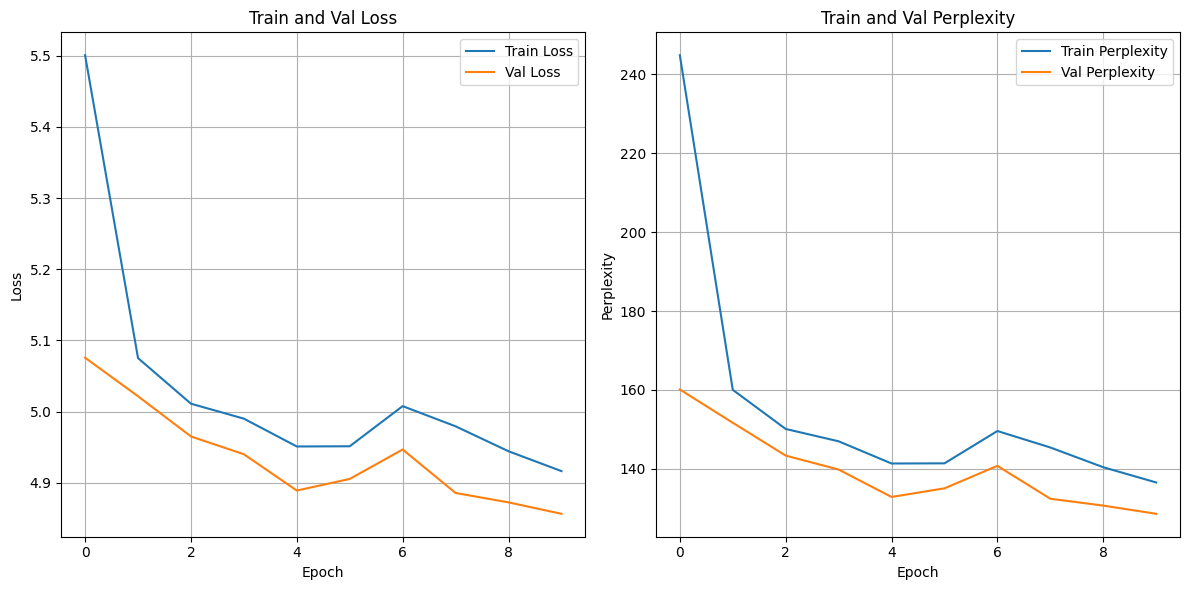

In [ ]:
plot_losses_and_perplexity(losses_train, losses_val, perplexities_train,
                           perplexities_val)  # plot losses and perplexity

## Exemplo de uso

In [ ]:
# Função para gerar texto

def generate_text(model, vocab, text, context_size, device, max_len=100, temperature=1.0):
    model.eval()

    # tokenizando texto inicial
    if not text.strip():
        tokenized = [vocab["<sos>"]]
    else:
        text = text.lower()
        tokenized = tokenize(text, vocab)
    #print(f'Texto tokenizado: {tokenized} / de_code: {de_tokenize(tokenized, vocab)}')

    generated_text = tokenized.copy()

    with torch.no_grad():
        for _ in range(max_len):
            # convertendo para tensor
            tensor = torch.LongTensor(generated_text[-context_size:]).unsqueeze(0).to(device)

            # passando pelo modelo
            output, _ = model(tensor)

            # pega logitos da ultima posição
            output = output[0, -1, :] / temperature # vocab_size
            logits = F.softmax(output, dim=-1)

            # amostrando próximo token
            next_token = torch.multinomial(logits, num_samples=1).item() # pega próximo token de acordo com a distribuição

            # adicionando ao texto
            generated_text.append(next_token)

            # se o token for <eos>, parar
            if next_token == vocab['<eos>']:
                break

    # convertando de volta para texto
    generated_text = de_tokenize(generated_text, vocab)
    #print(f'Texto gerado: {generated_text}')

    return generated_text

In [ ]:
# ===== TESTE DE GERAÇÃO =====

print("TESTE DE GERAÇÃO DE TEXTO")
print("=" * 40)

texts = [
    "dom casmurro era um homem",
    "eram nove horas da noite",
    "ela disse que não era",
    "A aurora para os dois acadêmicos",
    "", # Teste com texto vazio
    "batatinha quando nasce",
    "o modelo de linguagem é",
    "só sei que nada sei"
]

for i in texts:
    print(f"Texto inicial: {i}")
    print(f"Texto temp=1: {generate_text(model, vocab, i, context_size, device, max_len=100, temperature=1.0)}")
    print(f"Texto temp=0.8: {generate_text(model, vocab, i, context_size, device, max_len=100, temperature=0.8)}")
    print(f"Texto temp=1.2: {generate_text(model, vocab, i, context_size, device, max_len=100, temperature=1.2)}")

    print("=" * 40)

TESTE DE GERAÇÃO DE TEXTO
Texto inicial: dom casmurro era um homem
Texto temp=1: dom casmurro era um homem nessa simples tempo o essencial eclesiástico de <eos>
Texto temp=0.8: dom casmurro era um homem , porque ele por ele como <eos>
Texto temp=1.2: dom casmurro era um homem . esta casaca e trinta cavalheiros do <eos>
Texto inicial: eram nove horas da noite
Texto temp=1: eram nove horas da noite , we no chão que produzido os sentia o destino <eos>
Texto temp=0.8: eram nove horas da noite . lá a companhia <eos>
Texto temp=1.2: eram nove horas da noite , abriu o levara <eos>
Texto inicial: ela disse que não era
Texto temp=1: ela disse que não era a eleição , mas por cinco horas a carta , lhe levara para tirar ao paço do <eos>
Texto temp=0.8: ela disse que não era possível <eos>
Texto temp=1.2: ela disse que não era o acanhamento reflexões pálidas e daí a tendência uma prova de ler , e na noite na esposa . assim refletiu outra . não entende : <eos>
Texto inicial: A aurora para os dois ac